# Ex05 - Segmentação

Nesta atividade vamos tentar explorar um pouco técnicas de segmentação e entender que para conseguirmos uma boa segmentação, muitas vezes é preciso pré-processar as imagens (filtrar, por exemplo). Além disso, é preciso saber escolher o melhor valor para cada parâmetro do método, o que pode não ser trivial. 

Vimos em aula que há diversas técnicas de segmentação. Aqui, testaremos apenas 2 técnicas: *Otsu* e *Watershed*. A técnica de *Otsu* é baseada em limiarização ([Notebook: Segmentação por Otsu](14_Segmentacao_por_Otsu.ipynb)) e pode ser *Global* ou *Local*. Já a técnica de watershed é baseada na topografia da imagem e, para obter bons resultados, é normalmente necessário definir marcadores (sementes) para guiar a segmentação ([Notebook: Segmentação por Watershed](15_Exemplo_de_Segmentacao_por_Watershed.ipynb)). 

Cada uma destas técnicas têm pontos fracos e fortes e podem resultar em segmentações diferentes ([Notebook: Comparando Otsu e Watershed](16_Comparando_Otsu_e_Watershed.ipynb)).

In [97]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

from skimage import measure
from skimage.filters.rank import otsu
from skimage.filters import threshold_otsu, sobel

Text(0.5, 1.0, 'Imagem original')

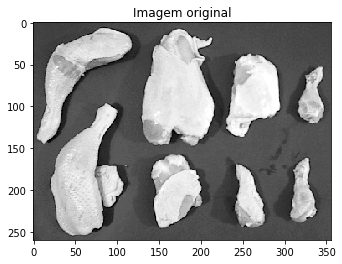

In [98]:
f_pil = Image.open('../data/chickparts.tif')
f = np.array(f_pil) #convert pillow image to numpy array
plt.imshow(f, cmap='gray')
plt.title('Imagem original')

### Parte 1 - Segmentação pelo método de Limiarização de Otsu

Segmente as partes do frango pelo método de limiarização de Otsu, tanto global quanto local.

First, let us study the Otsu algorithm:

The algorithm exhaustively searches for the threshold that minimizes the intra-class variance, defined as a weighted sum of variances of the two classes:


![equation.PNG](equation.PNG)
The class probability <strong>w<sub>0,1</sub></strong> is computed from the <strong>L</strong> bins of the histogram:


![weight.PNG](weight.PNG)
We want to minimize the intra-class variance, which is the same as maximizing the inter-class variance:


![minmax.PNG](minmax.PNG)
which is expressed in terms of class probabilities <strong>w</strong> and class means <strong>&mu;</strong> (represented by <strong>m</strong>'s in the code), where the class means <strong>m<sub>0</sub>(t)</strong>, <strong>m<sub>1</sub>(t)</strong>, and <strong>m<sub>T</sub></strong> are:


![means.PNG](means.PNG)
In sum, the Otsu algorithm iteratively computes the class probabilities and class means, to calculate the inter-class variances. We then assign the threshold to the position of maximum inter-class variance.

So now, having explained the Otsu algorithm, let's implement it and run it on the image shown above:

In [99]:
#Otsu algorithm for threshold calculation
#exhaustive search for the threshold that maximizes the inter-class variance, 
################# defined as a weighted sum of variances of the two classes:

def global_otsu(f):
    n = np.product(np.shape(f)) #get total numper of pixels in image
    h = 1.*np.bincount(f.ravel()) / n  #transf. image to 1-D array and run a bincount on the array
    if len(h) == 1: return 1,1
    x = np.arange(np.product(np.shape(h))) #generate aranged 1-D array with same size as "h"
    
    #Weights w0 and w1 are the probabilities of the two classes separated by a threshold t, and (sigma0)^2 and (sigma1)^2 are variances of these two classes
    w0 = np.cumsum(h) #set weights "w0" array as the cumulative sum along h
    w1 = 1 - w0 #set weights "w1" array
    eps = 1e-10
    m0 = np.cumsum(x * h) / (w0 + eps) #set class mean "m0"
    mt = m0[-1]
    m1 = (mt - m0[0:-1]*w0[0:-1]) / w1[0:-1] #set class mean "m1"
    sB2 = w0[0:-1] * w1[0:-1] * ((m0[0:-1] - m1)**2) #calculate inter-class variance iteratively
    t = np.argmax(sB2) #threshold is the position of max. inter-class variance
    v = sB2[t] #inter-class variance value at threshold position
    st2 = sum((x-mt)**2 * h) #total inter-class variance
    eta = v / st2 #threshold position inter-class variance in %
    return t, eta

[ 1098  4763 28137 23017   708   828  3313  5697 14485 10514]
Threshold "t" =  140


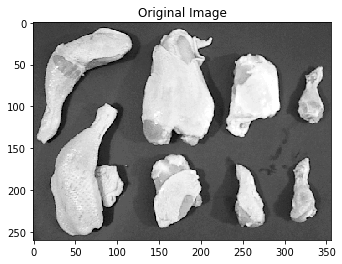

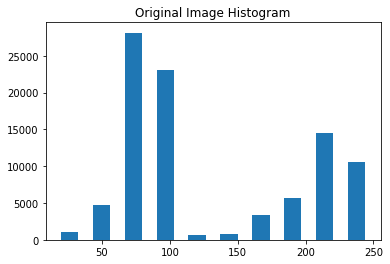

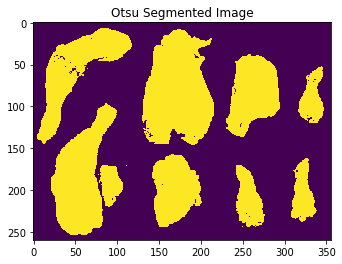

In [100]:
t,c = global_otsu(f) #execute otsu algorithm
g = f > t #True in positions with values higher than the threshold (false otherwise)

#generate histogram
nbins = 20
h, bin_edges = np.histogram(f)
print(h)
w=255./nbins
bin_centers = bin_edges[1:]-(w/2)

print('Threshold "t" = ',t)

#show original image, histogram, and segmented image
plt.figure(1)
plt.imshow(f,cmap='gray')
plt.title('Original Image')
plt.figure(2)
plt.bar(bin_centers, h, width=w)
plt.title('Original Image Histogram')

plt.figure(3)
plt.title('Otsu Segmented Image')
plt.imshow(g)

As we can see, the Otsu algorithm achieved pretty good results. There are however, some imperfections. As we can see, darker areas in the pieces of chicken ended up being classified as "background", which is undesirable. 

To fix this, let's try applying the same otsu threshold idea, but with an adaptive threshold. This means that the threshold value is the weighted mean for the local neighborhood of a pixel subtracted by a constant (Alternatively the threshold can be determined dynamically by a given function, using the ‘generic’ method). For this we will use skimage.filters.threshold_local, which returns the threshold mask to be applied on our original image. That is what we do in the "adaptive_otsu" method:

In [101]:
from skimage.filters import threshold_local
#Adaptive Threshold Otsu Segmentation
def adaptive_otsu(image, window_size, method='gaussian', offset=0, mode='reflect', param=None, cval=0):
    g = f > threshold_local(f,window_size,method,offset,mode,param,cval) #True in positions with values higher than the
    return g                                                            ##threshold (false otherwise)

Text(0.5, 1.0, 'Adaptive Threshold Otsu Segmented Image')

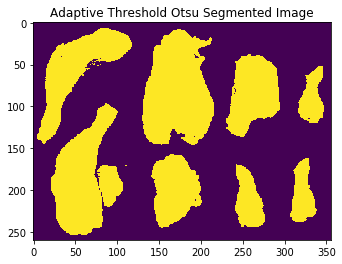

In [102]:
#Show result of Adpative Otsu segmentation
otsu_seg = adaptive_otsu(f,255)
plt.imshow(otsu_seg)
plt.title('Adaptive Threshold Otsu Segmented Image')

As we can see, most of the errors in the constant threshold method have been eliminated. But, of course, this second method is also not perfect. A clear example of this is the chicken piece in the bottom left corner of the image. The first method shows two pieces completely seperate. The second method shows improvement, as the "two pieces" are now connected in some places. 

The desired result, however, is that they were completely connected as they are in the original image. We can easily deduce why this area is hard to resolve: in the original image, the left part creates a shade on the right part, which makes the area darker than the usual chicken color, causing a mistake for background.

### Parte 2 - Segmentação pelo método de Watershed

Podemos resolver o mesmo problema de segmentação das partes do frango aplicando agora o método de Watershed. Você precisa primeiro escolher de alguma forma os marcadores e depois utilizar a função *watershed* da bilbioteca *skimage.segmentation*.

First, let us study the <strong>Watershed Algorithm</strong>:

The inspiration behind the algorithm lies in geography: what geography calls a <strong>"watershed"</strong> is a region of land that assists in draining water (usually rainwater) into a river. It is an area of high ground through which water flows into the river.

In image processing, the <strong>"Watershed Algorithm"</strong> is a transformation on grayscale images. The aim of this technique is to segment the image, typically when two regions-of-interest are close to each other — i.e, their edges touch.
This transformation technique treats the image as a topographic map, with the intensity of each pixel representing the height. Returning to our geographical analogy, the dark areas can be intuitively considered to be ‘lower’ in height, and can represent troughs, while bright areas can be considered to be ‘higher’, acting as hills or as a mountain ridge.

This lead to the creation of the method we call <strong>Watershed by Flooding</strong>. Once again with our analogy, the source of water is placed in the flooded catchment basins (the areas with low intensity). Areas where the floodwater from different basins meet are identified. Barriers in the form of pixels are built in these areas. Consequently, these barriers act as partitions in the image, and the image is considered to be segmented.

Now that we have understood the idea behind the algorithm, how do we actually apply it?

In this case, we will run <strong>Marker-Controlled Flooding</strong>: we will simulate the flooding discussed above from specific <strong>seed points</strong> or <strong>markers</strong>. A common choice for the markers are the local minima of the gradient of the image (this is what we will use), but the method works on any specific marker, either selected manually by the user or determined automatically by another algorithm.

<p>Marker-controlled Watershed needs at least two images to run:</p>
<ul><li> The <b>Input</b> image: a 2D or 3D grayscale image to flood, usually the gradient of an image.</li>
<li> The <b>Marker</b> image: an image of the same dimensions as the input containing the seed points or markers as connected regions of voxels, each of them with a different label. They correspond usually to the local minima of the input image, but they can be set arbitrarily.</li></ul>
<p>And it can optionally admit a third image:
</p>
<ul><li> The <b>Mask</b> image: a binary image of the same dimensions as input and marker which can be used to restrict the areas of application of the algorithm. Set to "None" to run the method on the whole input image.</li></ul>
<p>Rest of parameters:
</p>
<ul><li> <b>Binary markers</b>: select to specify that markers are binary and need to be labeled.</li>
<li> <b>Calculate dams</b>: select to enable the calculation of watershed lines.</li>
<li> <b>Use diagonal connectivity</b>: select to allow the flooding in diagonal directions.</li></ul>
<p>Output:
</p>
<ul><li> Labeled image containing the catchment basins and (optionally) watershed lines (dams).</li></ul>

In [103]:
import skimage.morphology as mm
from skimage.segmentation import watershed, join_segmentations
from skimage.segmentation import mark_boundaries

First, we apply apply a <strong>Morphological Closing</strong> on the image. The morphological closing on an image is defined as a dilation followed by an erosion. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. This tends to “close” up (dark) gaps between (bright) features.

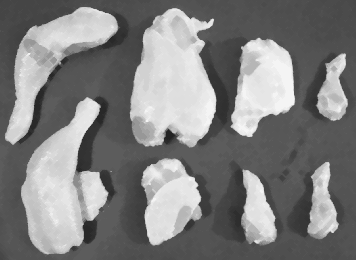

In [104]:
f = Image.open('../data/chickparts.tif')
a = np.array(f) #pillow image to numpy array
b = mm.closing(a, mm.disk(2)) #apply Morphological Closing
Image.fromarray(b)

Now we run a comparisson on the above images. All pixels >= 100 are turned to 1 and the rest to 0. 

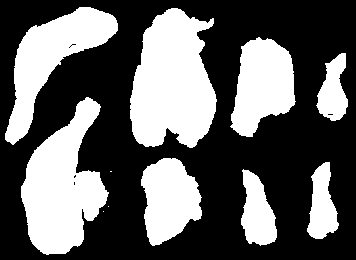

In [105]:
c = (a >= 100) #True in positions with values higher than the 100 (false otherwise)
Image.fromarray(c.astype(np.uint8)*255)

But as we can see, there are still a few dark spots (where watershed will not be applied) in places we want to apply watershed to. To solve this, we run the <em>remove_small_holes</em> from the <em>skimage.morphology</em> module. This method removes contiguous holes smaller than a specified size.

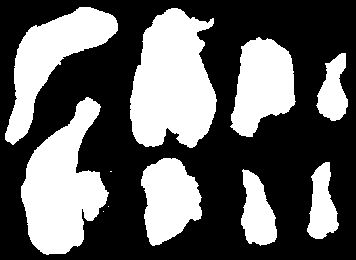

In [106]:
d = mm.remove_small_holes(c,30) #apply small hole removal
Image.fromarray(d.astype(np.uint8)*255) #show mask to be used in watershed

Now that we have our mask, we need our markers. That is where the gradient comes into play. 

Observation: instead of calculating markers with a manual application of the gradient to the image, we could use a sobel filter to generate the marker image. (for example, substitute the <strong>"h"</strong> array below for <em>h = sobel(f)</em>, where <em>sobel()</em> is the method from the <em>skimage.filters</em> module).

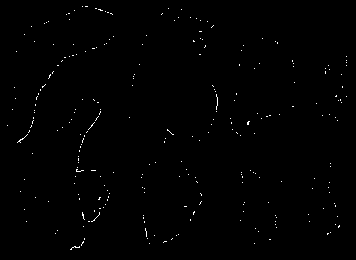

In [107]:
f = mm.h_minima(a,30) #find local minima in the image to use as markers
markers = f.astype(np.uint8)*2
Image.fromarray(markers.astype(np.uint8)*255) #show markers to be used in watershed

Now that we have both the mask and the markers, let's finally apply the watershed algorithm to segment our image:

Text(0.5, 1.0, 'Watershed Lines on Original Image')

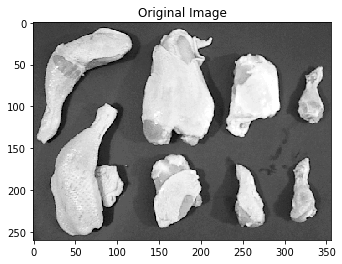

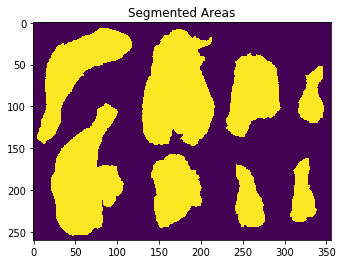

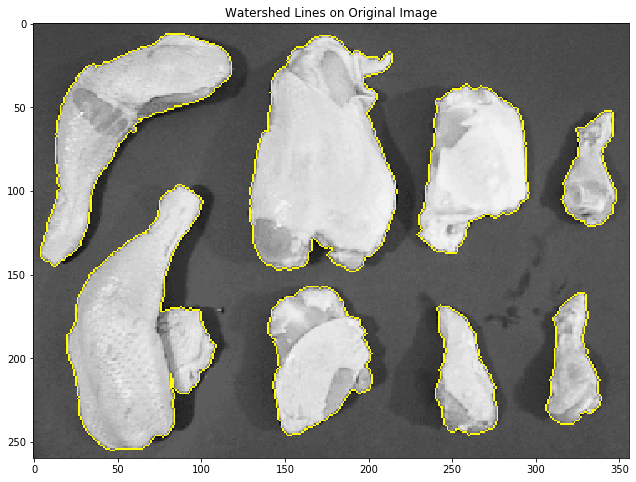

In [108]:
markers = markers.astype(np.uint8)*255
i = watershed(a,markers,mask=d.astype(np.uint8)*255) #run watershed on image, with the above markers and mask

#Show Original image, segmented areas, and Original Image with Watershed lines
plt.figure(1)
plt.imshow(a, cmap='gray')
plt.title('Original Image')

plt.figure(2)
plt.imshow(i)
plt.title('Segmented Areas')

plt.figure(3,figsize=(14,8))
plt.imshow(mark_boundaries(a,i))
plt.title('Watershed Lines on Original Image')

### Parte 3 - Comparação de segmentações

Agora que você obteve mais de um resultado de segmentação, faça a comparação deles de forma qualitativa e quantitativa. Normalmente a avaliação qualititativa é feita através de algum tipo de visualização das 2 segmentações. Não basta visualizar uma imagem ao lado da outra. Utilize formas de visualização mais apropriadas para visualizar as diferenças entre as imagens. Já a avaliação quantitativa deve ser feita utilizando-se uma ou mais métricas.

Now let's compare the <strong>Otsu</strong> and <strong>Watershed</strong> segmentations. First we want a qualitive comparisson, so we use the <em>join_segmentations</em> method from the <em>skimage.segmentation</em> method. This overlays the two segmentations with different colors, so we can easily spot the difference between them.

Text(0.5, 1.0, 'Otsu and Watershed Segmentations Overlayed')

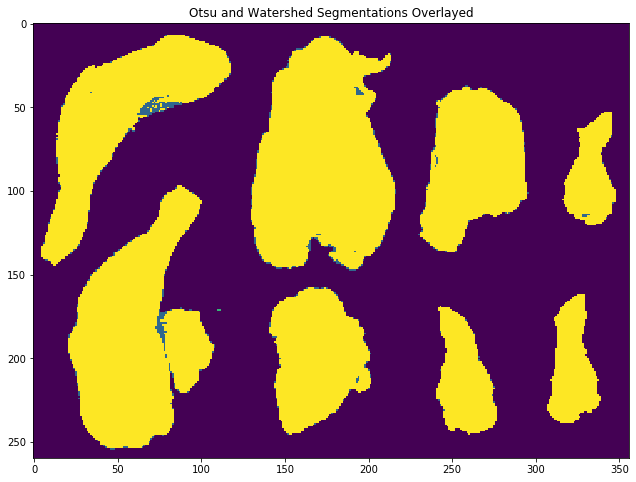

In [109]:
from skimage.segmentation import join_segmentations
overlay = join_segmentations(otsu_seg,i) #overlay adaptive otsu and watershed segmentations

#Show the result of join_segmentations method
plt.figure(1,figsize=(14,8))
plt.imshow(overlay)
plt.title('Otsu and Watershed Segmentations Overlayed')

We can't say either is perfect due to the fact that we don't have a <strong>target prediction</strong> (a segmentation which is considered the perfect segmentation and which we would want to achieve, also known as the <strong>Ground Truth</strong>). We can though, easily tell that the Watershed Segmentation (blue) is better than the Otsu segmentation (yellow) because the Otsu segmentation has holes (which are filled with watershed) where there clearly shouldn't be and, in general, the border of the chicken pieces are smoother with watershed (closer to as seen in the original image).

Now let's evaluate the segmentations quantitavely. Again, without a <strong>Ground Truth</strong>, we can establish some metrics to evaluate the segmentations with, but these metrics serve only to compare them and not to say if either is better in any aspect

The percentage of area that should be segmented is an interesting metric for comparing the segmentations quantitavely:

In [114]:
i2 = (i>127) #make watershed segementation binary (was on 0-255 scale)
x=otsu_seg.shape
u=i.shape
#Calculate pixel concentrations and print them comprehensively
print('Concentration of segmented parts in Otsu Segmentaion: ' + str(np.sum(otsu_seg)/(x[0]*x[1])))
print('Percentage of area segmented: ' + str(100*np.sum(otsu_seg)/(x[0]*x[1])) + '%\n')
print('Concentration of segmented parts in Watershed Segmentation: ' + str(np.sum(i2)/(u[0]*u[1])))
print('Percentage of area segmented: ' + str(100*np.sum(i2)/(x[0]*x[1])) + '%')

Concentration of segmented parts in Otsu Segmentaion: 0.3761776145203112
Percentage of area segmented: 37.61776145203112%

Concentration of segmented parts in Watershed Segmentation: 0.38418323249783926
Percentage of area segmented: 38.418323249783924%


If we had a <strong>Ground Truth</strong>, than there are a few metrics that are traditionaly used to evaluate the quality of segmentations:

<ul><li><strong>Pixel Accuracy:</strong> the percent of pixels in your image that are classified correctly. This is however, not a very good metric in most cases: high pixel accuracy doesn’t always imply superior segmentation ability. This is due to <strong>Class Imbalance</strong>: When our classes are extremely imbalanced, it means that a class or some classes dominate the image, while some other classes make up only a small portion of the image. Consequently, our pixel accuracy can be very high, having missed various classes. Unfortunately, class imbalance is prevalent in many real world data sets, so it can’t be ignored. </ul></li> 

<ul><li><strong>IOU:</strong> Intersection-Over-Union, also known as the Jaccard Index, is one of the most commonly used metrics in semantic segmentation because it's a very straightforward metric that’s extremely effective. IoU is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth. For both binary and multi-class segmentation, the mean IoU of the image is calculated by taking the IoU of each class and averaging them. This is a much better metric than pixel accuracy</ul></li> 


![iou.PNG](iou.PNG)
<ul><li><strong>Dice Coeficient:</strong> The dice coeficient, also known as the <strong>F1 Score</strong>, is 2 *(the Area of Overlap) divided by the total number of pixels in both images. This metric is very similar to the IOU and they are positively correlated: if one says model A is better than model B at segmenting an image, then the other will say the same. However they are slightly different and will, in most cases, yiel slightly different results.</ul></li>


![f1.PNG](f1.PNG)